<a href="https://colab.research.google.com/github/filizolalab/CADD2021/blob/main/Normalizing_Flow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install --pre deepchem
!pip install --pre rdkit-pypi 
!pip install --pre PubChemPy

     |████████████████████████████████| 609 kB 11.2 MB/s 
     |████████████████████████████████| 20.4 MB 1.5 MB/s 
  Created wheel for PubChemPy: filename=PubChemPy-1.0.4-py3-none-any.whl size=13835 sha256=16fb37d35e861d44a6b61ff075014f5e5643bca228ce7ea65c447318f5306773
  Stored in directory: /root/.cache/pip/wheels/7c/3d/8c/8192697412e9899dc55bbbb08bbc1197bef333caaa2a71c448
Successfully built PubChemPy


In [2]:
# install SELFIES
!git clone https://github.com/aspuru-guzik-group/selfies.git
%cd selfies
!pip install .
%cd ..

Cloning into 'selfies'...
remote: Enumerating objects: 2745, done.
remote: Counting objects: 100% (590/590), done.
remote: Compressing objects: 100% (443/443), done.
remote: Total 2745 (delta 377), reused 282 (delta 146), pack-reused 2155
Receiving objects: 100% (2745/2745), 16.03 MiB | 8.70 MiB/s, done.
Resolving deltas: 100% (1770/1770), done.
/content/selfies
Processing /content/selfies
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Created wheel for selfies: filename=selfies-2.0.0-py3-none-any.whl size=33231 sha256=37880963a5ce89b6449ee8e0b592ab98c097d6b55cabfa8418e741d53c85c339
  Stored in directory: /tmp/pip-ephem-wheel-cache-o7ez_61j/

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os

import deepchem as dc
from deepchem.models.normalizing_flows import NormalizingFlow, NormalizingFlowModel
from deepchem.models.optimizers import Adam
from deepchem.data import NumpyDataset
from deepchem.splits import RandomSplitter
from deepchem.molnet import load_tox21

import rdkit
from rdkit.Chem import Draw

In [4]:
from IPython.display import Image, display

import selfies as sf
import tensorflow as tf
import tensorflow_probability as tfp

In [5]:
tfd = tfp.distributions
tfb = tfp.bijectors
tfk = tf.keras
tfk.backend.set_floatx('float64')

In [6]:
# Download from MolNet
tasks, datasets, transformers = dc.molnet.load_qm9(featurizer='ECFP')
df = pd.DataFrame(data={'smiles': datasets[0].ids})



In [7]:
len(df)
data = df[['smiles']].sample(2500, random_state=42)

In [8]:


sf.set_semantic_constraints()  # reset constraints
constraints = sf.get_semantic_constraints()
constraints['?'] = 3

sf.set_semantic_constraints(constraints)
constraints



{'?': 3,
 'B': 3,
 'B+1': 2,
 'B-1': 4,
 'Br': 1,
 'C': 4,
 'C+1': 5,
 'C-1': 3,
 'Cl': 1,
 'F': 1,
 'H': 1,
 'I': 1,
 'N': 3,
 'N+1': 4,
 'N-1': 2,
 'O': 2,
 'O+1': 3,
 'O-1': 1,
 'P': 5,
 'P+1': 6,
 'P-1': 4,
 'S': 6,
 'S+1': 7,
 'S-1': 5}

In [9]:
def preprocess_smiles(smiles):
  return sf.encoder(smiles)  

data['selfies'] = data['smiles'].apply(preprocess_smiles)

In [10]:
data['len'] = data['smiles'].apply(lambda x: len(x))
data.sort_values(by='len').head()

,smiles,selfies,len
14460,N#CC(=O)C#N,[N][#C][C][=Branch1][C][=O][C][#N],11
22082,[H]C(=O)c1nnon1,[H][C][=Branch1][C][=O][C][N][=N][O][N][=Ring1...,15
15217,[H]c1nn([H])nc1[H],[H][C][=N][N][Branch1][C][H][N][=C][Ring1][=Br...,18
57634,[H]c1nnc(C#N)nc1[H],[H][C][=N][N][=C][Branch1][Ring1][C][#N][N][=C...,19
53275,[H]C#CC(=O)C(F)(F)F,[H][C][#C][C][=Branch1][C][=O][C][Branch1][C][...,19


In [11]:
selfies_list = np.asanyarray(data.selfies)
selfies_alphabet = sf.get_alphabet_from_selfies(selfies_list)
selfies_alphabet.add('[nop]')  # Add the "no operation" symbol as a padding character
selfies_alphabet = list(sorted(selfies_alphabet))

pad_to_len = max(sf.len_selfies(s) for s in selfies_list)  # was largest_selfie_len
symbol_to_idx = {s: i for i, s in enumerate(selfies_alphabet)}


In [12]:
selfies_alphabet

['[#Branch1]',
 '[#Branch2]',
 '[#C]',
 '[#N]',
 '[/C]',
 '[/H]',
 '[/N+1]',
 '[/N]',
 '[/O]',
 '[=Branch1]',
 '[=Branch2]',
 '[=C]',
 '[=N+1]',
 '[=N]',
 '[=O]',
 '[=Ring1]',
 '[=Ring2]',
 '[Branch1]',
 '[Branch2]',
 '[C+1]',
 '[C-1]',
 '[CH1+1]',
 '[C]',
 '[F]',
 '[H]',
 '[N+1]',
 '[N-1]',
 '[NH1+1]',
 '[NH1]',
 '[NH2+1]',
 '[N]',
 '[O-1]',
 '[O]',
 '[P]',
 '[Ring1]',
 '[Ring2]',
 '[S]',
 '[\\C]',
 '[\\H]',
 '[\\N]',
 '[nop]']

In [13]:
#onehots = [sf.selfies_to_encoding(
#    selfie,
#    vocab_stoi=symbol_to_idx,
#    pad_to_len=pad_to_len, 
#    enc_type='one_hot') for selfie in selfies_list[0:1000]]


clean_selfies_list=[]
for i,selfie in enumerate(selfies_list):
   try:
     sf.selfies_to_encoding(selfie,vocab_stoi=symbol_to_idx,pad_to_len=pad_to_len, enc_type='one_hot')
     clean_selfies_list.append(selfie)
   except:
     print(i)  


In [14]:
onehots = sf.batch_selfies_to_flat_hot(clean_selfies_list, symbol_to_idx, pad_to_len)

In [15]:
input_tensor = tf.convert_to_tensor(onehots, dtype='float64')
noise_tensor = tf.random.uniform(shape=input_tensor.shape, minval=0, maxval=1, dtype='float64')
dequantized_data = tf.add(input_tensor, noise_tensor)

In [16]:
ds = NumpyDataset(dequantized_data)  # Create a DeepChem dataset
splitter = RandomSplitter()
train, val, test = splitter.train_valid_test_split(dataset=ds, seed=42)
train_idx, val_idx, test_idx = splitter.split(dataset=ds, seed=42)

dim = len(train.X[0])  # length of one-hot encoded vectors
train.X.shape  # 2000 samples, N-dimensional one-hot vectors that represent molecules

(2000, 2542)

In [17]:
base_dist = tfd.MultivariateNormalDiag(loc=np.zeros(dim), scale_diag=np.ones(dim))

if dim % 2 == 0:
    permutation = tf.cast(np.concatenate((np.arange(dim / 2, dim), np.arange(0, dim / 2))), tf.int32)
else:
    permutation = tf.cast(np.concatenate((np.arange(dim / 2 + 1, dim), np.arange(0, dim / 2))), tf.int32)

In [18]:
num_layers = 8
flow_layers = []

Made = tfb.AutoregressiveNetwork(
    params=2,
    hidden_units=[512, 512], 
    activation='relu')

for i in range(num_layers):
    flow_layers.append((tfb.MaskedAutoregressiveFlow(shift_and_log_scale_fn=Made)))
    permutation = tf.cast(np.random.permutation(np.arange(0, dim)), tf.int32)
    flow_layers.append(tfb.Permute(permutation=permutation))

In [19]:
%%time
nf = NormalizingFlow(base_distribution=base_dist,flow_layers=flow_layers)
samples = nf.flow.sample(5)

CPU times: user 2min 12s, sys: 3.07 s, total: 2min 15s
Wall time: 2min 16s


In [20]:
samples

<tf.Tensor: shape=(5, 2542), dtype=float64, numpy=
array([[ 0.23947747, -0.77054045, -0.2945698 , ..., -1.12321262,
         1.60271483,  0.67242643],
       [-1.22297218, -1.36349732,  0.33800797, ..., -0.91107809,
         0.80395918,  0.63537228],
       [ 0.65199923, -0.74336413,  0.63342884, ..., -1.28128012,
        -0.20205953, -0.983117  ],
       [ 1.05778981, -0.84099039,  0.9227753 , ...,  1.06544803,
         0.20374991, -1.72946362],
       [-0.21205345, -1.06567554, -0.44268397, ..., -0.77471161,
         1.92013885,  0.77058349]])>

In [21]:
nfm = NormalizingFlowModel(nf, learning_rate=1e-4, batch_size=128)

In [22]:
losses = []
val_losses = []


In [23]:
%%time
max_epochs = 20 # maximum number of epochs of the training

for epoch in range(max_epochs):
  loss = nfm.fit(train, nb_epoch=1, all_losses=losses)
  val_loss = nfm.create_nll(val.X)
  val_losses.append(val_loss.numpy())

CPU times: user 22.7 s, sys: 3.47 s, total: 26.2 s
Wall time: 50.4 s


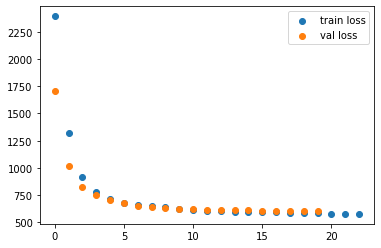

In [24]:
f, ax = plt.subplots()
ax.scatter(range(len(losses)), losses, label='train loss')
ax.scatter(range(len(val_losses)), val_losses, label='val loss')
plt.legend(loc='upper right');

In [25]:
generated_samples = nfm.flow.sample(2)  # generative modeling
#log_probs = nfm.flow.log_prob(generated_samples)  # probability density estimation

In [27]:
mols = tf.math.floor(generated_samples)  # quantize data
mols = tf.clip_by_value(mols, 0, 1)  # Set negative values to 0 and values > 1 to 1
mols_list = mols.numpy().tolist()

# Add padding characters if needed
for mol in mols_list:
  for i in range(pad_to_len):
    row = mol[len(selfies_alphabet) * i: len(selfies_alphabet) * (i + 1)]
    if all(elem == 0 for elem in row):
      mol[len(selfies_alphabet) * (i+1) - 1] = 1

In [35]:
idx_to_symbol = {v: k for k, v in symbol_to_idx.items()}
mols2 = sf.batch_flat_hot_to_selfies(mols_list, idx_to_symbol)
mols2

['[=N][=Branch2][/C][#N][=O][=Ring1][=Ring2][P][/N+1][/H][\\C][=Ring2][C][C][#Branch2][C][Branch1][Branch1][/N+1][/H][/C][#C][Branch1][nop][/O][Branch1][=Branch2][#Branch1][nop][Branch1][O][=C][/H][C-1][=O][C-1][NH1][/O][#Branch1][S][H][/H][=C][/N+1][=Ring2][Branch1][#Branch2][N][nop][P][#Branch1][#C][nop][#Branch1][=Ring1][=Ring1][=Ring2][/C][=C][=C][#Branch2][#N]',
 '[/N+1][/C][#C][nop][=N][C][/H][/C][H][C][Branch1][=Branch2][Ring2][Branch1][=Branch1][=Branch2][Ring1][=Branch1][\\C][H][/O][#Branch1][C][C][C][C][#C][/N][nop][Branch2][nop][nop][#Branch1][=Ring1][Ring2][C][#N][/N][C+1][=O][Ring1][=N][=Branch1][nop][C-1][#C][=N][N][=N+1][=O][=Branch1][#Branch2][#Branch2][/C][Branch2][/O][=Branch2][N][/N][\\C][nop][/H]']

In [29]:
from rdkit import RDLogger  
from rdkit import Chem
RDLogger.DisableLog('rdApp.*')  # suppress error messages

valid_count = 0
valid_selfies, invalid_selfies = [], []
for idx, selfies in enumerate(mols2):
  try:
    if Chem.MolFromSmiles(sf.decoder(mols2[idx]), sanitize=True) is not None:
        valid_count += 1
        valid_selfies.append(selfies)
    else:
      invalid_selfies.append(selfies)
  except Exception:
    pass
print('%.2f' % (valid_count / len(mols)),  ' fraction of generated samples are valid molecules.')



1.00  fraction of generated samples are valid molecules.


In [30]:
gen_mols = [Chem.MolFromSmiles(sf.decoder(vs)) for vs in valid_selfies]

In [31]:
def display_images(filenames):
    """Helper to pretty-print images."""
    for file in filenames:
      display(Image(file))

def mols_to_pngs(mols, basename="generated_mol"):
    """Helper to write RDKit mols to png files."""
    filenames = []
    for i, mol in enumerate(mols):
        filename = "%s%d.png" % (basename, i)
        Draw.MolToFile(mol, filename)
        filenames.append(filename)
    return filenames

In [32]:
gen_mols


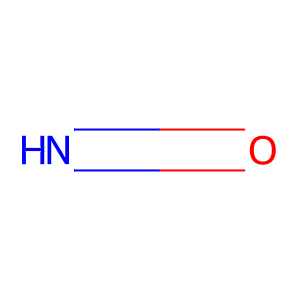

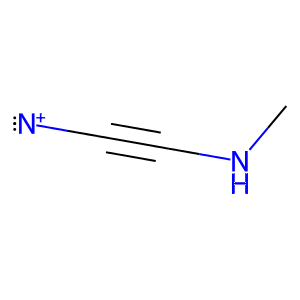

In [34]:
display_mols = []
for molc in gen_mols:
  display_mols.append(molc)

display_images(mols_to_pngs(display_mols))

In [49]:
smiles1 = 'CN1CCC23C4C1CC5=C2C(=C(C=C5)O)OC3C(C=C4)O'
selfies1 = sf.encoder(smiles1)
selfies1

'[C][N][C][C][C][C][C][Ring1][=Branch1][C][C][=C][Ring1][=Branch1][C][=Branch1][=Branch2][=C][Branch1][Branch1][C][=C][Ring1][=Branch1][O][O][C][Ring1][=N][C][Branch1][Branch1][C][=C][Ring1][#C][O]'

In [50]:
#selfies1='[=N][=Branch2][/C][#N][=O][=Ring1][=Ring2][P][/N+1][/H][\\C][=Ring2][C][C][#Branch2][C][Branch1][Branch1][/N+1][/H][/C][#C][Branch1][nop][/O][Branch1][=Branch2][#Branch1][nop][Branch1][O][=C][/H][C-1][=O][C-1][NH1][/O][#Branch1][S][H][/H][=C][/N+1][=Ring2][Branch1][#Branch2][N][nop][P][#Branch1][#C][nop][#Branch1][=Ring1][=Ring1][=Ring2][/C][=C][=C][#Branch2][#N]'
molc1 = Chem.MolFromSmiles(sf.decoder(selfies1), sanitize=True)
sf.decoder(selfies1)

'CN1CCC23C4C1CC5=C2C(=C(C=C5)O)OC3C(C=C4)O'

In [53]:
selfies2='[C][N][C][C][C][C][C][Ring1][C][C][=C][=Branch1][C][=Branch1][=Branch2][=C][Branch1][Branch1][C][=C][Ring1][=Branch1][O][O][C][Ring1][=N][C][Branch1][Branch1][C][=C][Ring1][#C][O]'
molc2 = Chem.MolFromSmiles(sf.decoder(selfies2), sanitize=True)
sf.decoder(selfies2)

'CNC1C2CC=C3C=CC(C=C3)OOC1C(C=C2)O'

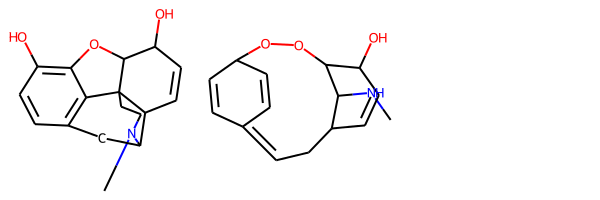

In [54]:
Draw.MolsToGridImage([molc1,molc2])